In [1]:
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
from torchvision.transforms import functional as F
from torchvision import transforms, models
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet


In [2]:
# Paths to JSON files and data directory
train_json_path = 'G:/food-101.zip/food-101/meta/train.json'
test_json_path = 'G:/food-101.zip/food-101/meta/test.json'
data_dir = 'G:/food-101.zip/food-101/images'

In [3]:
print("Loading JSON files...")
# Load JSON files
with open(train_json_path, 'r') as f:
    train_data = json.load(f)
with open(test_json_path, 'r') as f:
    test_data = json.load(f)

Loading JSON files...


In [4]:
print("Splitting train data into training and validation sets...")
# Split train data into train and validation
train_data_split = {}
val_data_split = {}

for cls, items in train_data.items():
    train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)
    train_data_split[cls] = train_items
    val_data_split[cls] = val_items

Splitting train data into training and validation sets...


In [5]:
# Create custom dataset class
class FoodDataset(DatasetFolder):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.classes = list(self.data.keys())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = [(os.path.join(self.root_dir, item + ".jpg"), self.class_to_idx[cls])
                        for cls, items in self.data.items() for item in items]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:  # Check if the image has 1 channel
            image = image.repeat(3, 1, 1)  # Convert 1-channel image to 3-channel
        if self.transform:
            image = F.to_pil_image(image)
            image = self.transform(image)
        return image, label

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
print("Initializing datasets and dataloaders...")
# Initialize datasets and dataloaders
train_dataset = FoodDataset(data=train_data_split, root_dir=data_dir, transform=transform)
val_dataset = FoodDataset(data=val_data_split, root_dir=data_dir, transform=transform)
test_dataset = FoodDataset(data=test_data, root_dir=data_dir, transform=transform)

Initializing datasets and dataloaders...


In [8]:
# Use a small subset of the dataset for initial testing
def get_subset(dataset, fraction=0.2):
    num_samples = int(len(dataset) * fraction)
    subset_indices = random.sample(range(len(dataset)), num_samples)
    return Subset(dataset, subset_indices)

train_subset = get_subset(train_dataset, fraction=0.2)
val_subset = get_subset(val_dataset, fraction=0.2)
test_subset = get_subset(test_dataset, fraction=0.2)

print(f"Number of training images: {len(train_subset)}")
print(f"Number of validation images: {len(val_subset)}")
print(f"Number of testing images: {len(test_subset)}")

Number of training images: 12120
Number of validation images: 3030
Number of testing images: 5050


In [9]:
batch_size = 2048
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [11]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# print("Loading pre-trained ResNet18 model...")
# model = models.resnet18(pretrained=True)
print("Loading pre-trained EfficientNet B7 model...")
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=101)
# num_ftrs = model.fc.in_features
num_ftrs = model._fc.in_features  # or model._classifier.in_features

model.fc = nn.Linear(num_ftrs, 101)  # 101 classes
model = model.to(device)

Using device: cuda
Loading pre-trained EfficientNet B7 model...
Loaded pretrained weights for efficientnet-b7


In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# def prune_layer(layer, pruning_rate):
#     """Prunes the given layer by setting a percentage of its weights to zero."""
#     print(f"Pruning layer with pruning rate: {pruning_rate}")
#     with torch.no_grad():
#         weight = layer.weight.data.abs().clone()
#         threshold = torch.quantile(weight, pruning_rate)
#         mask = weight.ge(threshold).float()
#         layer.weight.data.mul_(mask)
#         return mask

In [ ]:
# def prune_layer(layer, pruning_rate):
#     """Prunes the given layer by setting a percentage of its weights to zero."""
#     print(f"Pruning layer with pruning rate: {pruning_rate}")
#     with torch.no_grad():
#         weight = layer.weight.data.abs().clone()
#         threshold = torch.quantile(weight, pruning_rate)
#         mask = weight.ge(threshold).float()
#         layer.weight.data.mul_(mask)
#         return mask.clone().detach()  # Return a copy of the mask tensor

In [ ]:
# def prune_layer(layer, pruning_rate):
#     """Prunes the given layer by setting a percentage of its weights to zero."""
#     print(f"Pruning layer with pruning rate: {pruning_rate}")
#     with torch.no_grad():
#         weight = layer.weight.data.abs().clone()
#         threshold = torch.quantile(weight, pruning_rate)
#         mask = weight.ge(threshold).float()
#         layer.weight.data.mul_(mask)
#         return torch.tensor(mask, dtype=torch.float32)  # Convert mask to tensor explicitly

In [13]:
def prune_layer(layer, pruning_rate):
    """Prunes the given layer by setting a percentage of its weights to zero."""
    print(f"Pruning layer with pruning rate: {pruning_rate}")
    with torch.no_grad():
        weight = layer.weight.data.abs().clone()
        threshold = torch.quantile(weight, pruning_rate)
        mask = weight.ge(threshold).float()
        layer.weight.data.mul_(mask)
        # print(f"Mask type: {type(mask)}")
        # print(f"Mask value: {mask}")
        return mask


In [ ]:
# def fine_tune_model(model, train_loader, criterion, optimizer, num_epochs):
#     """Fine-tunes the model after pruning."""
#     print("Starting fine-tuning...")
#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch + 1}/{num_epochs}")
#         running_loss = 0.0
#         train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
#         for inputs, labels in train_loader_tqdm:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
#         epoch_loss = running_loss / len(train_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

In [14]:
pruning_rates_log = []

def fine_tune_model(model, train_loader, criterion, optimizer, num_epochs):
    """Fine-tunes the model after pruning."""
    print("Starting fine-tuning...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

In [15]:
def layer_sensitivity_analysis(model, data_loader, criterion):
    """Performs sensitivity analysis for each layer."""
    print("Starting layer sensitivity analysis...")
    sensitivities = {}
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            print(f"Analyzing layer: {name}")
            initial_loss = evaluate_model(model, data_loader, criterion)
            mask = prune_layer(layer, 0.1)  # Prune 10% as a test
            new_loss = evaluate_model(model, data_loader, criterion)
            sensitivities[name] = new_loss - initial_loss
            layer.weight.data.mul_(mask)  # Revert pruning
            print(f"Sensitivity for layer {name}: {sensitivities[name]}")
    return sensitivities

In [16]:
def evaluate_model(model, data_loader, criterion):
    """Evaluates the model performance."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating model", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    accuracy = 100 * total_correct / total_samples
    print(f"Validation Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    return average_loss

In [17]:
print("Performing sensitivity analysis...")
# Perform sensitivity analysis
sensitivities = layer_sensitivity_analysis(model, val_loader, criterion)

Performing sensitivity analysis...
Starting layer sensitivity analysis...
Analyzing layer: _conv_stem


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _conv_stem: 4.0531158447265625e-06
Analyzing layer: _blocks.0._depthwise_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.0._depthwise_conv: 9.059906005859375e-06
Analyzing layer: _blocks.0._se_reduce


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.0._se_reduce: -5.9604644775390625e-06
Analyzing layer: _blocks.0._se_expand


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.0._se_expand: -6.4373016357421875e-06
Analyzing layer: _blocks.0._project_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.0._project_conv: 2.384185791015625e-06
Analyzing layer: _blocks.1._depthwise_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.1._depthwise_conv: -1.7642974853515625e-05
Analyzing layer: _blocks.1._se_reduce


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.1._se_reduce: -1.2636184692382812e-05
Analyzing layer: _blocks.1._se_expand


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.1._se_expand: 2.0265579223632812e-05
Analyzing layer: _blocks.1._project_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.1._project_conv: 8.344650268554688e-06
Analyzing layer: _blocks.2._depthwise_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.2._depthwise_conv: -4.0531158447265625e-06
Analyzing layer: _blocks.2._se_reduce


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.2._se_reduce: -2.384185791015625e-05
Analyzing layer: _blocks.2._se_expand


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.2._se_expand: 1.5974044799804688e-05
Analyzing layer: _blocks.2._project_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.2._project_conv: 1.4543533325195312e-05
Analyzing layer: _blocks.3._depthwise_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.3._depthwise_conv: -2.9802322387695312e-05
Analyzing layer: _blocks.3._se_reduce


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.3._se_reduce: -2.384185791015625e-07
Analyzing layer: _blocks.3._se_expand


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7687, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.3._se_expand: -9.775161743164062e-06
Analyzing layer: _blocks.3._project_conv


Validation Loss: 5.7687, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.3._project_conv: 1.1444091796875e-05
Analyzing layer: _blocks.4._expand_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.4._expand_conv: 1.6927719116210938e-05
Analyzing layer: _blocks.4._depthwise_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.4._depthwise_conv: 5.054473876953125e-05
Analyzing layer: _blocks.4._se_reduce


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.4._se_reduce: 6.4373016357421875e-06
Analyzing layer: _blocks.4._se_expand


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.4._se_expand: -1.71661376953125e-05
Analyzing layer: _blocks.4._project_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.4._project_conv: 3.409385681152344e-05
Analyzing layer: _blocks.5._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.5._expand_conv: 7.62939453125e-06
Analyzing layer: _blocks.5._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.5._depthwise_conv: -1.0251998901367188e-05
Analyzing layer: _blocks.5._se_reduce


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.5._se_reduce: 6.4373016357421875e-06
Analyzing layer: _blocks.5._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.5._se_expand: 3.0994415283203125e-06
Analyzing layer: _blocks.5._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.5._project_conv: 2.1219253540039062e-05
Analyzing layer: _blocks.6._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.6._expand_conv: 3.0994415283203125e-05
Analyzing layer: _blocks.6._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.6._depthwise_conv: -2.0265579223632812e-05
Analyzing layer: _blocks.6._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.6._se_reduce: 1.430511474609375e-06
Analyzing layer: _blocks.6._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.6._se_expand: 9.5367431640625e-07
Analyzing layer: _blocks.6._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.6._project_conv: -2.1219253540039062e-05
Analyzing layer: _blocks.7._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.7._expand_conv: 2.0503997802734375e-05
Analyzing layer: _blocks.7._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.7._depthwise_conv: 2.4080276489257812e-05
Analyzing layer: _blocks.7._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.7._se_reduce: -1.0728836059570312e-05
Analyzing layer: _blocks.7._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.7._se_expand: -1.1920928955078125e-06
Analyzing layer: _blocks.7._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.7._project_conv: 3.4332275390625e-05
Analyzing layer: _blocks.8._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.8._expand_conv: -3.4332275390625e-05
Analyzing layer: _blocks.8._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.8._depthwise_conv: 2.7894973754882812e-05
Analyzing layer: _blocks.8._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.8._se_reduce: 5.7220458984375e-06
Analyzing layer: _blocks.8._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.8._se_expand: -1.2636184692382812e-05
Analyzing layer: _blocks.8._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.8._project_conv: 8.821487426757812e-06
Analyzing layer: _blocks.9._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.9._expand_conv: 1.1444091796875e-05
Analyzing layer: _blocks.9._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.9._depthwise_conv: 1.8835067749023438e-05
Analyzing layer: _blocks.9._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.9._se_reduce: -2.86102294921875e-06
Analyzing layer: _blocks.9._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.9._se_expand: 1.430511474609375e-05
Analyzing layer: _blocks.9._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.9._project_conv: 3.814697265625e-06
Analyzing layer: _blocks.10._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.10._expand_conv: 1.5497207641601562e-05
Analyzing layer: _blocks.10._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.10._depthwise_conv: -4.76837158203125e-07
Analyzing layer: _blocks.10._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.10._se_reduce: 3.814697265625e-06
Analyzing layer: _blocks.10._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.10._se_expand: 1.0251998901367188e-05
Analyzing layer: _blocks.10._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.10._project_conv: 8.821487426757812e-06
Analyzing layer: _blocks.11._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.11._expand_conv: -4.029273986816406e-05
Analyzing layer: _blocks.11._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.11._depthwise_conv: -2.86102294921875e-06
Analyzing layer: _blocks.11._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.11._se_reduce: 1.430511474609375e-06
Analyzing layer: _blocks.11._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.11._se_expand: -2.8371810913085938e-05
Analyzing layer: _blocks.11._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.11._project_conv: 0.00023126602172851562
Analyzing layer: _blocks.12._expand_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.12._expand_conv: -1.0013580322265625e-05
Analyzing layer: _blocks.12._depthwise_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.12._depthwise_conv: -8.106231689453125e-06
Analyzing layer: _blocks.12._se_reduce


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.12._se_reduce: -6.198883056640625e-06
Analyzing layer: _blocks.12._se_expand


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.12._se_expand: -5.9604644775390625e-06
Analyzing layer: _blocks.12._project_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.12._project_conv: 9.059906005859375e-06
Analyzing layer: _blocks.13._expand_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.13._expand_conv: 1.6450881958007812e-05
Analyzing layer: _blocks.13._depthwise_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.13._depthwise_conv: -1.0728836059570312e-05
Analyzing layer: _blocks.13._se_reduce


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.13._se_reduce: 4.76837158203125e-06
Analyzing layer: _blocks.13._se_expand


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.13._se_expand: 3.5762786865234375e-06
Analyzing layer: _blocks.13._project_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.13._project_conv: -1.9073486328125e-06
Analyzing layer: _blocks.14._expand_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.14._expand_conv: 8.821487426757812e-06
Analyzing layer: _blocks.14._depthwise_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.14._depthwise_conv: -1.33514404296875e-05
Analyzing layer: _blocks.14._se_reduce


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.14._se_reduce: -1.7642974853515625e-05
Analyzing layer: _blocks.14._se_expand


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.14._se_expand: 3.218650817871094e-05
Analyzing layer: _blocks.14._project_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.14._project_conv: -3.886222839355469e-05
Analyzing layer: _blocks.15._expand_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.15._expand_conv: -2.384185791015625e-07
Analyzing layer: _blocks.15._depthwise_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.15._depthwise_conv: -8.821487426757812e-06
Analyzing layer: _blocks.15._se_reduce


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.15._se_reduce: 9.5367431640625e-07
Analyzing layer: _blocks.15._se_expand


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.15._se_expand: 3.5762786865234375e-06
Analyzing layer: _blocks.15._project_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.15._project_conv: 2.1457672119140625e-05
Analyzing layer: _blocks.16._expand_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.16._expand_conv: -7.62939453125e-06
Analyzing layer: _blocks.16._depthwise_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.16._depthwise_conv: -5.245208740234375e-06
Analyzing layer: _blocks.16._se_reduce


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.16._se_reduce: 8.106231689453125e-06
Analyzing layer: _blocks.16._se_expand


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.16._se_expand: -3.814697265625e-06
Analyzing layer: _blocks.16._project_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.16._project_conv: -2.47955322265625e-05
Analyzing layer: _blocks.17._expand_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.17._expand_conv: 2.5510787963867188e-05
Analyzing layer: _blocks.17._depthwise_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.17._depthwise_conv: 0.0
Analyzing layer: _blocks.17._se_reduce


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.17._se_reduce: -3.814697265625e-06
Analyzing layer: _blocks.17._se_expand


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.17._se_expand: -4.291534423828125e-06
Analyzing layer: _blocks.17._project_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.17._project_conv: 2.4318695068359375e-05
Analyzing layer: _blocks.18._expand_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.18._expand_conv: 2.384185791015625e-07
Analyzing layer: _blocks.18._depthwise_conv


Validation Loss: 5.7692, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.18._depthwise_conv: -0.00011563301086425781
Analyzing layer: _blocks.18._se_reduce


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.18._se_reduce: 6.67572021484375e-06
Analyzing layer: _blocks.18._se_expand


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.18._se_expand: 7.62939453125e-06
Analyzing layer: _blocks.18._project_conv


Validation Loss: 5.7691, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.18._project_conv: -3.361701965332031e-05
Analyzing layer: _blocks.19._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.19._expand_conv: -3.62396240234375e-05
Analyzing layer: _blocks.19._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.19._depthwise_conv: 9.775161743164062e-06
Analyzing layer: _blocks.19._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.19._se_reduce: -1.71661376953125e-05
Analyzing layer: _blocks.19._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.19._se_expand: -4.76837158203125e-06
Analyzing layer: _blocks.19._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.19._project_conv: 1.52587890625e-05
Analyzing layer: _blocks.20._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.20._expand_conv: -1.1444091796875e-05
Analyzing layer: _blocks.20._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.20._depthwise_conv: 1.1682510375976562e-05
Analyzing layer: _blocks.20._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.20._se_reduce: -4.291534423828125e-06
Analyzing layer: _blocks.20._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.20._se_expand: -4.5299530029296875e-06
Analyzing layer: _blocks.20._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.20._project_conv: -1.9073486328125e-06
Analyzing layer: _blocks.21._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.21._expand_conv: -7.3909759521484375e-06
Analyzing layer: _blocks.21._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.21._depthwise_conv: -3.5762786865234375e-06
Analyzing layer: _blocks.21._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.21._se_reduce: 9.5367431640625e-07
Analyzing layer: _blocks.21._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.21._se_expand: 5.7220458984375e-06
Analyzing layer: _blocks.21._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.21._project_conv: -1.33514404296875e-05
Analyzing layer: _blocks.22._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.22._expand_conv: -2.1457672119140625e-06
Analyzing layer: _blocks.22._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.22._depthwise_conv: 1.8596649169921875e-05
Analyzing layer: _blocks.22._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.22._se_reduce: -1.1920928955078125e-06
Analyzing layer: _blocks.22._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.22._se_expand: 3.814697265625e-06
Analyzing layer: _blocks.22._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.22._project_conv: 5.7220458984375e-06
Analyzing layer: _blocks.23._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.23._expand_conv: -2.384185791015625e-07
Analyzing layer: _blocks.23._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.23._depthwise_conv: 7.152557373046875e-07
Analyzing layer: _blocks.23._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.23._se_reduce: 0.0
Analyzing layer: _blocks.23._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.23._se_expand: 0.0
Analyzing layer: _blocks.23._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.23._project_conv: -7.867813110351562e-06
Analyzing layer: _blocks.24._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.24._expand_conv: 7.152557373046875e-07
Analyzing layer: _blocks.24._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.24._depthwise_conv: 1.430511474609375e-06
Analyzing layer: _blocks.24._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.24._se_reduce: 0.0
Analyzing layer: _blocks.24._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.24._se_expand: -9.5367431640625e-07
Analyzing layer: _blocks.24._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.24._project_conv: -1.430511474609375e-06
Analyzing layer: _blocks.25._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.25._expand_conv: -5.9604644775390625e-06
Analyzing layer: _blocks.25._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.25._depthwise_conv: 5.4836273193359375e-06
Analyzing layer: _blocks.25._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.25._se_reduce: -2.384185791015625e-07
Analyzing layer: _blocks.25._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.25._se_expand: 0.0
Analyzing layer: _blocks.25._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.25._project_conv: 1.1920928955078125e-06
Analyzing layer: _blocks.26._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.26._expand_conv: -5.9604644775390625e-06
Analyzing layer: _blocks.26._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.26._depthwise_conv: 2.1457672119140625e-06
Analyzing layer: _blocks.26._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.26._se_reduce: -2.384185791015625e-07
Analyzing layer: _blocks.26._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.26._se_expand: -1.9073486328125e-06
Analyzing layer: _blocks.26._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.26._project_conv: 5.245208740234375e-06
Analyzing layer: _blocks.27._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.27._expand_conv: -6.67572021484375e-06
Analyzing layer: _blocks.27._depthwise_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.27._depthwise_conv: 1.1444091796875e-05
Analyzing layer: _blocks.27._se_reduce


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.27._se_reduce: -1.430511474609375e-06
Analyzing layer: _blocks.27._se_expand


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.27._se_expand: 1.1920928955078125e-06
Analyzing layer: _blocks.27._project_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.27._project_conv: -4.76837158203125e-06
Analyzing layer: _blocks.28._expand_conv


Validation Loss: 5.7690, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.28._expand_conv: -6.747245788574219e-05
Analyzing layer: _blocks.28._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.28._depthwise_conv: 6.67572021484375e-06
Analyzing layer: _blocks.28._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.28._se_reduce: -4.076957702636719e-05
Analyzing layer: _blocks.28._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.28._se_expand: 3.790855407714844e-05
Analyzing layer: _blocks.28._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.28._project_conv: -9.059906005859375e-06
Analyzing layer: _blocks.29._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.29._expand_conv: -2.8848648071289062e-05
Analyzing layer: _blocks.29._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.29._depthwise_conv: 6.4373016357421875e-06
Analyzing layer: _blocks.29._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.29._se_reduce: -2.384185791015625e-06
Analyzing layer: _blocks.29._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.29._se_expand: -2.2411346435546875e-05
Analyzing layer: _blocks.29._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.29._project_conv: 4.9114227294921875e-05
Analyzing layer: _blocks.30._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.30._expand_conv: -3.6716461181640625e-05
Analyzing layer: _blocks.30._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.30._depthwise_conv: -1.3828277587890625e-05
Analyzing layer: _blocks.30._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.30._se_reduce: 3.337860107421875e-06
Analyzing layer: _blocks.30._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.30._se_expand: 2.1457672119140625e-06
Analyzing layer: _blocks.30._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.30._project_conv: 1.1682510375976562e-05
Analyzing layer: _blocks.31._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.31._expand_conv: -1.239776611328125e-05
Analyzing layer: _blocks.31._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.31._depthwise_conv: -1.4066696166992188e-05
Analyzing layer: _blocks.31._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.31._se_reduce: 1.049041748046875e-05
Analyzing layer: _blocks.31._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.31._se_expand: -9.059906005859375e-06
Analyzing layer: _blocks.31._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.31._project_conv: 6.9141387939453125e-06
Analyzing layer: _blocks.32._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.32._expand_conv: 4.76837158203125e-07
Analyzing layer: _blocks.32._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.32._depthwise_conv: 2.384185791015625e-07
Analyzing layer: _blocks.32._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.32._se_reduce: 2.86102294921875e-06
Analyzing layer: _blocks.32._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.32._se_expand: 0.0
Analyzing layer: _blocks.32._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.32._project_conv: -1.1205673217773438e-05
Analyzing layer: _blocks.33._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.33._expand_conv: -2.86102294921875e-06
Analyzing layer: _blocks.33._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.33._depthwise_conv: 6.4373016357421875e-06
Analyzing layer: _blocks.33._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.33._se_reduce: -7.152557373046875e-07
Analyzing layer: _blocks.33._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.33._se_expand: -3.5762786865234375e-06
Analyzing layer: _blocks.33._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.33._project_conv: 1.7642974853515625e-05
Analyzing layer: _blocks.34._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.34._expand_conv: 5.4836273193359375e-06
Analyzing layer: _blocks.34._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.34._depthwise_conv: 4.5299530029296875e-06
Analyzing layer: _blocks.34._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.34._se_reduce: 1.1920928955078125e-06
Analyzing layer: _blocks.34._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.34._se_expand: 4.76837158203125e-07
Analyzing layer: _blocks.34._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.34._project_conv: 7.152557373046875e-07
Analyzing layer: _blocks.35._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.35._expand_conv: -4.00543212890625e-05
Analyzing layer: _blocks.35._depthwise_conv


Validation Loss: 5.7688, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.35._depthwise_conv: 2.2172927856445312e-05
Analyzing layer: _blocks.35._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.35._se_reduce: 2.384185791015625e-07
Analyzing layer: _blocks.35._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.35._se_expand: 0.0
Analyzing layer: _blocks.35._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.35._project_conv: 9.775161743164062e-06
Analyzing layer: _blocks.36._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.36._expand_conv: -1.1682510375976562e-05
Analyzing layer: _blocks.36._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.36._depthwise_conv: -7.152557373046875e-06
Analyzing layer: _blocks.36._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.36._se_reduce: -9.5367431640625e-07
Analyzing layer: _blocks.36._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.36._se_expand: 3.0994415283203125e-06
Analyzing layer: _blocks.36._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.36._project_conv: -3.337860107421875e-06
Analyzing layer: _blocks.37._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.37._expand_conv: 1.9073486328125e-06
Analyzing layer: _blocks.37._depthwise_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.37._depthwise_conv: -3.5762786865234375e-06
Analyzing layer: _blocks.37._se_reduce


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.37._se_reduce: -4.76837158203125e-07
Analyzing layer: _blocks.37._se_expand


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.37._se_expand: -7.152557373046875e-07
Analyzing layer: _blocks.37._project_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.37._project_conv: 2.1457672119140625e-06
Analyzing layer: _blocks.38._expand_conv


Validation Loss: 5.7689, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7687, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.38._expand_conv: -0.00015473365783691406
Analyzing layer: _blocks.38._depthwise_conv


Validation Loss: 5.7687, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7676, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.38._depthwise_conv: -0.0010788440704345703
Analyzing layer: _blocks.38._se_reduce


Validation Loss: 5.7676, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7674, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.38._se_reduce: -0.00026035308837890625
Analyzing layer: _blocks.38._se_expand


Validation Loss: 5.7674, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7673, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.38._se_expand: -6.842613220214844e-05
Analyzing layer: _blocks.38._project_conv


Validation Loss: 5.7673, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7668, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.38._project_conv: -0.0004744529724121094
Analyzing layer: _blocks.39._expand_conv


Validation Loss: 5.7668, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7666, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.39._expand_conv: -0.00023508071899414062
Analyzing layer: _blocks.39._depthwise_conv


Validation Loss: 5.7666, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7666, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.39._depthwise_conv: -3.147125244140625e-05
Analyzing layer: _blocks.39._se_reduce


Validation Loss: 5.7666, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7665, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.39._se_reduce: -9.5367431640625e-06
Analyzing layer: _blocks.39._se_expand


Validation Loss: 5.7665, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7666, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.39._se_expand: 1.2159347534179688e-05
Analyzing layer: _blocks.39._project_conv


Validation Loss: 5.7666, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.39._project_conv: -0.0005459785461425781
Analyzing layer: _blocks.40._expand_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.40._expand_conv: 5.888938903808594e-05
Analyzing layer: _blocks.40._depthwise_conv


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.40._depthwise_conv: 1.0728836059570312e-05
Analyzing layer: _blocks.40._se_reduce


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.40._se_reduce: -8.106231689453125e-06
Analyzing layer: _blocks.40._se_expand


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.40._se_expand: 4.3392181396484375e-05
Analyzing layer: _blocks.40._project_conv


Validation Loss: 5.7661, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.40._project_conv: -0.00011086463928222656
Analyzing layer: _blocks.41._expand_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.41._expand_conv: -1.33514404296875e-05
Analyzing layer: _blocks.41._depthwise_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.41._depthwise_conv: 2.09808349609375e-05
Analyzing layer: _blocks.41._se_reduce


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.41._se_reduce: -3.0994415283203125e-06
Analyzing layer: _blocks.41._se_expand


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.41._se_expand: -1.2636184692382812e-05
Analyzing layer: _blocks.41._project_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.41._project_conv: -3.6716461181640625e-05
Analyzing layer: _blocks.42._expand_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.42._expand_conv: 2.5987625122070312e-05
Analyzing layer: _blocks.42._depthwise_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.42._depthwise_conv: -4.76837158203125e-07
Analyzing layer: _blocks.42._se_reduce


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.42._se_reduce: 7.867813110351562e-06
Analyzing layer: _blocks.42._se_expand


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.42._se_expand: -6.4373016357421875e-06
Analyzing layer: _blocks.42._project_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.42._project_conv: -1.6450881958007812e-05
Analyzing layer: _blocks.43._expand_conv


Validation Loss: 5.7660, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.43._expand_conv: -9.1552734375e-05
Analyzing layer: _blocks.43._depthwise_conv


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.43._depthwise_conv: 1.9311904907226562e-05
Analyzing layer: _blocks.43._se_reduce


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.43._se_reduce: -9.5367431640625e-06
Analyzing layer: _blocks.43._se_expand


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.43._se_expand: -8.344650268554688e-06
Analyzing layer: _blocks.43._project_conv


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.43._project_conv: -1.9073486328125e-05
Analyzing layer: _blocks.44._expand_conv


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.44._expand_conv: -1.4543533325195312e-05
Analyzing layer: _blocks.44._depthwise_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.44._depthwise_conv: 3.886222839355469e-05
Analyzing layer: _blocks.44._se_reduce


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.44._se_reduce: -8.58306884765625e-06
Analyzing layer: _blocks.44._se_expand


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.44._se_expand: 5.245208740234375e-06
Analyzing layer: _blocks.44._project_conv


Validation Loss: 5.7659, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7657, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.44._project_conv: -0.00015878677368164062
Analyzing layer: _blocks.45._expand_conv


Validation Loss: 5.7657, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.45._expand_conv: 3.337860107421875e-05
Analyzing layer: _blocks.45._depthwise_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.45._depthwise_conv: -5.245208740234375e-06
Analyzing layer: _blocks.45._se_reduce


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.45._se_reduce: 2.6226043701171875e-06
Analyzing layer: _blocks.45._se_expand


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.45._se_expand: 4.5299530029296875e-06
Analyzing layer: _blocks.45._project_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.45._project_conv: 8.249282836914062e-05
Analyzing layer: _blocks.46._expand_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.46._expand_conv: -2.5272369384765625e-05
Analyzing layer: _blocks.46._depthwise_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.46._depthwise_conv: 1.6927719116210938e-05
Analyzing layer: _blocks.46._se_reduce


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.46._se_reduce: -1.1920928955078125e-06
Analyzing layer: _blocks.46._se_expand


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.46._se_expand: 3.5762786865234375e-06
Analyzing layer: _blocks.46._project_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.46._project_conv: -5.173683166503906e-05
Analyzing layer: _blocks.47._expand_conv


Validation Loss: 5.7658, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7657, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.47._expand_conv: -0.0001232624053955078
Analyzing layer: _blocks.47._depthwise_conv


Validation Loss: 5.7657, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.47._depthwise_conv: -1.7881393432617188e-05
Analyzing layer: _blocks.47._se_reduce


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.47._se_reduce: -8.821487426757812e-06
Analyzing layer: _blocks.47._se_expand


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.47._se_expand: 4.76837158203125e-06
Analyzing layer: _blocks.47._project_conv


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.47._project_conv: 1.1444091796875e-05
Analyzing layer: _blocks.48._expand_conv


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.48._expand_conv: -4.4345855712890625e-05
Analyzing layer: _blocks.48._depthwise_conv


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.48._depthwise_conv: -2.1219253540039062e-05
Analyzing layer: _blocks.48._se_reduce


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.48._se_reduce: 1.4781951904296875e-05
Analyzing layer: _blocks.48._se_expand


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.48._se_expand: -1.2159347534179688e-05
Analyzing layer: _blocks.48._project_conv


Validation Loss: 5.7656, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7655, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.48._project_conv: -6.508827209472656e-05
Analyzing layer: _blocks.49._expand_conv


Validation Loss: 5.7655, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.49._expand_conv: -0.0001316070556640625
Analyzing layer: _blocks.49._depthwise_conv


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.49._depthwise_conv: 1.4066696166992188e-05
Analyzing layer: _blocks.49._se_reduce


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.49._se_reduce: -9.5367431640625e-07
Analyzing layer: _blocks.49._se_expand


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.49._se_expand: 2.1457672119140625e-06
Analyzing layer: _blocks.49._project_conv


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.49._project_conv: 2.6464462280273438e-05
Analyzing layer: _blocks.50._expand_conv


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.50._expand_conv: 5.245208740234375e-06
Analyzing layer: _blocks.50._depthwise_conv


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.50._depthwise_conv: -7.43865966796875e-05
Analyzing layer: _blocks.50._se_reduce


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.50._se_reduce: -2.384185791015625e-07
Analyzing layer: _blocks.50._se_expand


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.50._se_expand: 1.6689300537109375e-06
Analyzing layer: _blocks.50._project_conv


Validation Loss: 5.7654, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7652, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.50._project_conv: -0.00012683868408203125
Analyzing layer: _blocks.51._expand_conv


Validation Loss: 5.7652, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7488, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.51._expand_conv: -0.016422510147094727
Analyzing layer: _blocks.51._depthwise_conv


Validation Loss: 5.7488, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7537, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.51._depthwise_conv: 0.004862308502197266
Analyzing layer: _blocks.51._se_reduce


Validation Loss: 5.7537, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7551, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.51._se_reduce: 0.0014042854309082031
Analyzing layer: _blocks.51._se_expand


Validation Loss: 5.7551, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7553, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.51._se_expand: 0.0002498626708984375
Analyzing layer: _blocks.51._project_conv


Validation Loss: 5.7553, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7538, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.51._project_conv: -0.0015659332275390625
Analyzing layer: _blocks.52._expand_conv


Validation Loss: 5.7538, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7594, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.52._expand_conv: 0.0056688785552978516
Analyzing layer: _blocks.52._depthwise_conv


Validation Loss: 5.7594, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7601, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.52._depthwise_conv: 0.0006678104400634766
Analyzing layer: _blocks.52._se_reduce


Validation Loss: 5.7601, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7601, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.52._se_reduce: -4.673004150390625e-05
Analyzing layer: _blocks.52._se_expand


Validation Loss: 5.7601, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7596, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.52._se_expand: -0.0004570484161376953
Analyzing layer: _blocks.52._project_conv


Validation Loss: 5.7596, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7596, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.52._project_conv: -4.76837158203125e-07
Analyzing layer: _blocks.53._expand_conv


Validation Loss: 5.7596, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7611, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.53._expand_conv: 0.0014612674713134766
Analyzing layer: _blocks.53._depthwise_conv


Validation Loss: 5.7611, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7510, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.53._depthwise_conv: -0.010080337524414062
Analyzing layer: _blocks.53._se_reduce


Validation Loss: 5.7510, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7510, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.53._se_reduce: 4.887580871582031e-05
Analyzing layer: _blocks.53._se_expand


Validation Loss: 5.7510, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7525, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.53._se_expand: 0.001493215560913086
Analyzing layer: _blocks.53._project_conv


Validation Loss: 5.7525, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7524, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.53._project_conv: -7.462501525878906e-05
Analyzing layer: _blocks.54._expand_conv


Validation Loss: 5.7524, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7525, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.54._expand_conv: 9.441375732421875e-05
Analyzing layer: _blocks.54._depthwise_conv


Validation Loss: 5.7525, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7497, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.54._depthwise_conv: -0.0028243064880371094
Analyzing layer: _blocks.54._se_reduce


Validation Loss: 5.7497, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7495, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.54._se_reduce: -0.0002560615539550781
Analyzing layer: _blocks.54._se_expand


Validation Loss: 5.7495, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7490, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.54._se_expand: -0.00044536590576171875
Analyzing layer: _blocks.54._project_conv


Validation Loss: 5.7490, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7483, Validation Accuracy: 0.83%
Sensitivity for layer _blocks.54._project_conv: -0.0006957054138183594
Analyzing layer: _conv_head


Validation Loss: 5.7483, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7436, Validation Accuracy: 0.83%
Sensitivity for layer _conv_head: -0.004754066467285156
Analyzing layer: _fc


Validation Loss: 5.7436, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7614, Validation Accuracy: 0.83%
Sensitivity for layer _fc: 0.017871618270874023
Analyzing layer: fc


Validation Loss: 5.7614, Validation Accuracy: 0.83%
Pruning layer with pruning rate: 0.1


Validation Loss: 5.7614, Validation Accuracy: 0.83%
Sensitivity for layer fc: 0.0


In [18]:
# Determine adaptive pruning rates
total_sensitivity = sum(sensitivities.values())
pruning_rates = {name: max(0.0, min(1.0, sens / total_sensitivity)) for name, sens in sensitivities.items()}

print("Applying adaptive pruning...")
# Apply adaptive pruning
for name, layer in model.named_modules():
    if name in pruning_rates:
        prune_layer(layer, pruning_rates[name])


Applying adaptive pruning...
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0008111352649167775
Pruning layer with pruning rate: 0.0008760260861101197
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0024009603841536613
Pruning layer with pruning rate: 0.0017196067616235683
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0005515719801434088
Pruning layer with pruning rate: 0.00324454105966711
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.004055676324583888
Pruning layer with pruning rate: 3.24454105966711e-05
Pruning layer with pruning rate: 0.0013302618344635151
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.002336069562960319
Pruning layer with 

In [19]:
print("Fine-tuning the pruned model...")
# Fine-tune the pruned model
loss_log = []
pruning_rates_log = []
fine_tune_model(model, train_loader, criterion, optimizer, num_epochs=5)

Fine-tuning the pruned model...
Starting fine-tuning...
Epoch 1/5


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████| 6/6 [16:21<00:00, 163.61s/it, loss=4.68]


Epoch [1/5], Loss: 4.67975115776062
Epoch 2/5


Epoch 2/5: 100%|██████████████████████████████████████████████████████████████| 6/6 [05:58<00:00, 59.82s/it, loss=4.62]


Epoch [2/5], Loss: 4.615553140640259
Epoch 3/5


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████| 6/6 [17:26<00:00, 174.49s/it, loss=4.62]


Epoch [3/5], Loss: 4.615041097005208
Epoch 4/5


Epoch 4/5: 100%|██████████████████████████████████████████████████████████████| 6/6 [06:11<00:00, 61.95s/it, loss=4.61]


Epoch [4/5], Loss: 4.614466428756714
Epoch 5/5


Epoch 5/5: 100%|██████████████████████████████████████████████████████████████| 6/6 [06:05<00:00, 60.84s/it, loss=4.62]

Epoch [5/5], Loss: 4.615865310033162


In [20]:
print("Saving the pruned and fine-tuned model...")
# Save the model
torch.save(model.state_dict(), 'food101_EB7_pruned.pth')

Saving the pruned and fine-tuned model...


Evaluating the final model on the test set...


Testing model: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [01:11<00:00, 23.75s/it]


Test Accuracy: 1.17%


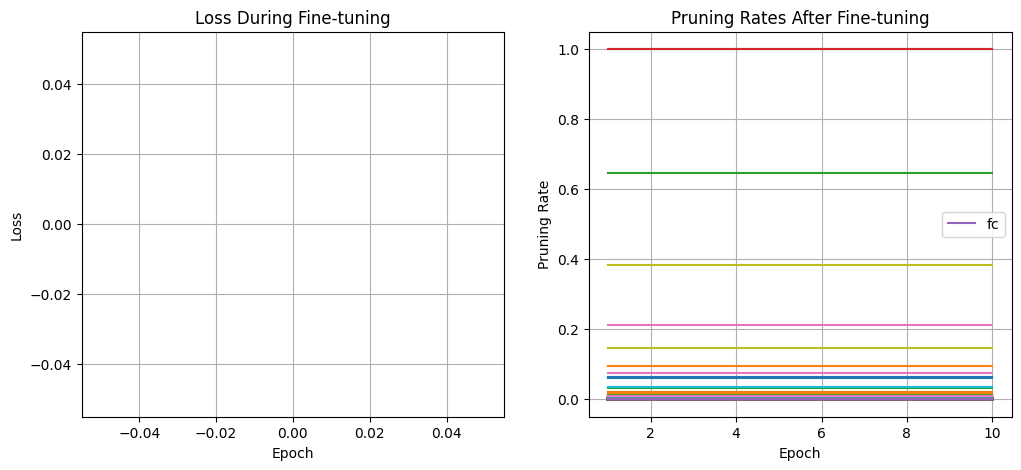

In [21]:
print("Evaluating the final model on the test set...")
# Evaluate the final model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing model"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting the loss log and pruning rates log
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_log) + 1), loss_log, marker='o')
plt.title('Loss During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
for name, rate in pruning_rates.items():
    plt.plot(range(1, 11), [rate] * 10, label=name)
plt.title('Pruning Rates After Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Pruning Rate')
plt.legend()
plt.grid(True)
plt.show()